## 1. Setup and Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 2. Positional Encoding

Since Transformers process all positions in parallel (no recurrence), we need to inject position information.

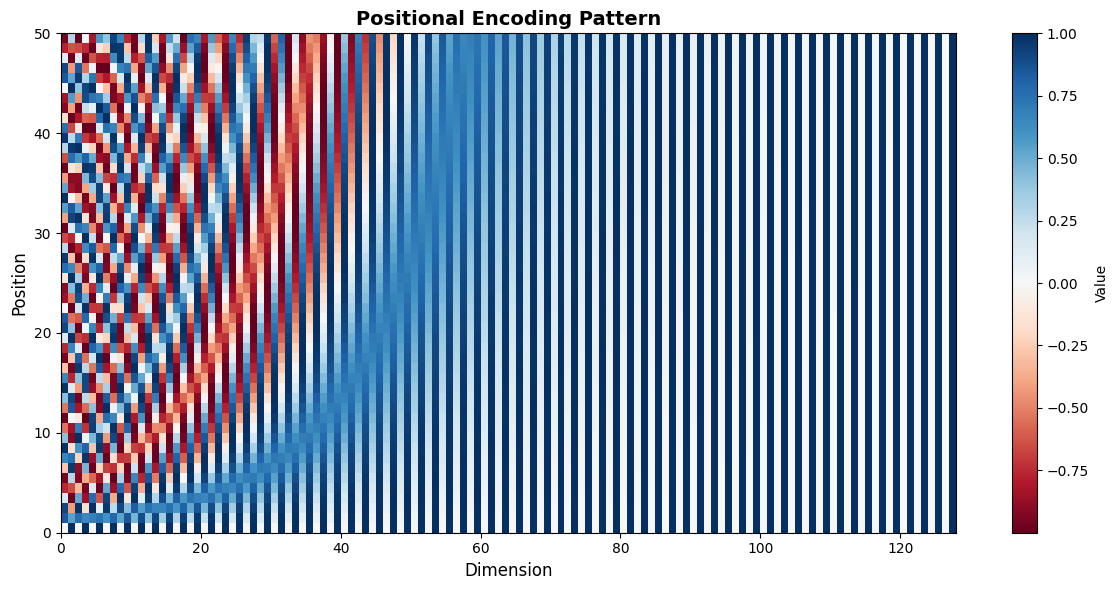

✓ Each position gets a unique 'fingerprint' of sine/cosine values


In [2]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        
        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        
        # Compute the div_term for sine and cosine
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                            -(math.log(10000.0) / d_model))
        
        # Apply sine to even indices, cosine to odd indices
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0)  # Add batch dimension
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        # x: [batch, seq_len, d_model]
        return x + self.pe[:, :x.size(1)]

# Visualize positional encodings
pe = PositionalEncoding(d_model=128, max_len=50)
encodings = pe.pe.squeeze().numpy()

plt.figure(figsize=(12, 6))
plt.pcolormesh(encodings, cmap='RdBu')
plt.xlabel('Dimension', fontsize=12)
plt.ylabel('Position', fontsize=12)
plt.colorbar(label='Value')
plt.title('Positional Encoding Pattern', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ Each position gets a unique 'fingerprint' of sine/cosine values")

## 3. Multi-Head Attention

The core mechanism that allows parallel attention computation.

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads  # Dimension per head
        
        # Linear projections for Q, K, V
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
    
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Q, K, V: [batch, num_heads, seq_len, d_k]
        
        # Calculate attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        attention = torch.softmax(scores, dim=-1)
        context = torch.matmul(attention, V)
        
        return context, attention
    
    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        
        # Linear projections and split into multiple heads
        Q = self.W_q(query).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(key).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(value).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        
        # Apply attention
        context, attention = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # Concatenate heads and apply final linear
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        output = self.W_o(context)
        
        return output, attention

print("✓ Multi-Head Attention defined")
print("  - Allows model to attend to different aspects simultaneously")
print("  - 8 heads = 8 different 'attention perspectives'")

✓ Multi-Head Attention defined
  - Allows model to attend to different aspects simultaneously
  - 8 heads = 8 different 'attention perspectives'


## 4. Feed-Forward Network

In [4]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # Expand, activate, contract
        return self.fc2(self.dropout(self.relu(self.fc1(x))))

print("✓ Feed-Forward Network defined")
print("  - Two linear layers with ReLU activation")
print("  - Typically 4x expansion: 512 → 2048 → 512")

✓ Feed-Forward Network defined
  - Two linear layers with ReLU activation
  - Typically 4x expansion: 512 → 2048 → 512


## 5. Encoder Layer

In [5]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()
        
        # Sub-layer 1: Multi-head self-attention
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        
        # Sub-layer 2: Feed-forward network
        self.ffn = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        # Self-attention with residual connection and layer norm
        attn_output, _ = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout1(attn_output))
        
        # Feed-forward with residual connection and layer norm
        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout2(ffn_output))
        
        return x

print("✓ Encoder Layer defined")
print("  - Self-Attention: Each word attends to all words")
print("  - Residual connections: x + SubLayer(x)")
print("  - Layer Norm: Stabilizes training")

✓ Encoder Layer defined
  - Self-Attention: Each word attends to all words
  - Residual connections: x + SubLayer(x)
  - Layer Norm: Stabilizes training


## 6. Decoder Layer

In [6]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(DecoderLayer, self).__init__()
        
        # Sub-layer 1: Masked self-attention
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        
        # Sub-layer 2: Cross-attention with encoder
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)
        
        # Sub-layer 3: Feed-forward network
        self.ffn = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout3 = nn.Dropout(dropout)
    
    def forward(self, x, encoder_output, src_mask=None, tgt_mask=None):
        # Masked self-attention (can't see future)
        attn_output, _ = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout1(attn_output))
        
        # Cross-attention with encoder output
        attn_output, _ = self.cross_attn(x, encoder_output, encoder_output, src_mask)
        x = self.norm2(x + self.dropout2(attn_output))
        
        # Feed-forward
        ffn_output = self.ffn(x)
        x = self.norm3(x + self.dropout3(ffn_output))
        
        return x

print("✓ Decoder Layer defined")
print("  - Masked Self-Attention: Can't see future tokens")
print("  - Cross-Attention: Attends to encoder outputs")
print("  - Feed-Forward: Same as encoder")

✓ Decoder Layer defined
  - Masked Self-Attention: Can't see future tokens
  - Cross-Attention: Attends to encoder outputs
  - Feed-Forward: Same as encoder


## 7. Complete Transformer Model

In [7]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512, num_heads=8,
                 num_encoder_layers=6, num_decoder_layers=6, d_ff=2048, 
                 dropout=0.1, max_len=5000):
        super(Transformer, self).__init__()
        
        # Embeddings
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        
        # Encoder stack
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_encoder_layers)
        ])
        
        # Decoder stack
        self.decoder_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_decoder_layers)
        ])
        
        # Output projection
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.d_model = d_model
    
    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        # Encode
        src_embedded = self.dropout(self.pos_encoding(
            self.src_embedding(src) * math.sqrt(self.d_model)
        ))
        
        encoder_output = src_embedded
        for layer in self.encoder_layers:
            encoder_output = layer(encoder_output, src_mask)
        
        # Decode
        tgt_embedded = self.dropout(self.pos_encoding(
            self.tgt_embedding(tgt) * math.sqrt(self.d_model)
        ))
        
        decoder_output = tgt_embedded
        for layer in self.decoder_layers:
            decoder_output = layer(decoder_output, encoder_output, src_mask, tgt_mask)
        
        # Project to vocabulary
        output = self.fc_out(decoder_output)
        
        return output

print("✓ Complete Transformer model defined")

✓ Complete Transformer model defined


## 8. Create Masks

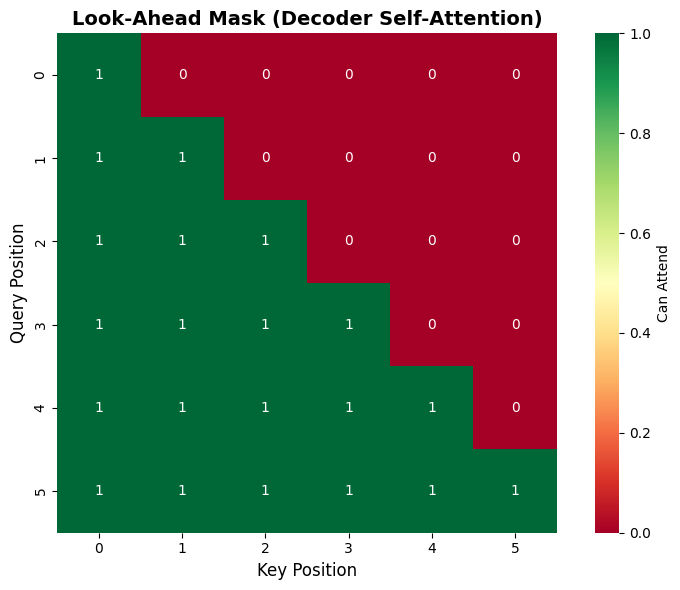


💡 Green (1) = Can attend, Red (0) = Cannot attend
   Position 0 can only see itself
   Position 2 can see positions 0, 1, 2 (no future peeking!)


In [8]:
def create_padding_mask(seq, pad_idx=0):
    """Mask padding tokens"""
    return (seq != pad_idx).unsqueeze(1).unsqueeze(2)

def create_look_ahead_mask(size):
    """Mask future tokens (for decoder self-attention)"""
    mask = torch.triu(torch.ones(size, size), diagonal=1)
    return mask == 0

# Visualize look-ahead mask
mask = create_look_ahead_mask(6)

plt.figure(figsize=(8, 6))
sns.heatmap(mask.numpy(), annot=True, fmt='d', cmap='RdYlGn', 
            cbar_kws={'label': 'Can Attend'}, square=True)
plt.xlabel('Key Position', fontsize=12)
plt.ylabel('Query Position', fontsize=12)
plt.title('Look-Ahead Mask (Decoder Self-Attention)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n💡 Green (1) = Can attend, Red (0) = Cannot attend")
print("   Position 0 can only see itself")
print("   Position 2 can see positions 0, 1, 2 (no future peeking!)")

## 9. Simple Training Example

In [9]:
# Small vocabulary for demonstration
SRC_VOCAB_SIZE = 100
TGT_VOCAB_SIZE = 100
D_MODEL = 128
NUM_HEADS = 4
NUM_LAYERS = 2
D_FF = 512

# Initialize model
model = Transformer(
    src_vocab_size=SRC_VOCAB_SIZE,
    tgt_vocab_size=TGT_VOCAB_SIZE,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    num_encoder_layers=NUM_LAYERS,
    num_decoder_layers=NUM_LAYERS,
    d_ff=D_FF
).to(device)

# Create dummy data
batch_size = 8
src_seq_len = 10
tgt_seq_len = 10

src = torch.randint(1, SRC_VOCAB_SIZE, (batch_size, src_seq_len)).to(device)
tgt = torch.randint(1, TGT_VOCAB_SIZE, (batch_size, tgt_seq_len)).to(device)

# Create masks
src_mask = create_padding_mask(src).to(device)
tgt_mask = create_look_ahead_mask(tgt_seq_len).unsqueeze(0).unsqueeze(0).to(device)

# Forward pass
output = model(src, tgt, src_mask, tgt_mask)

print(f"✓ Forward pass successful!")
print(f"  Input:  {src.shape}")
print(f"  Target: {tgt.shape}")
print(f"  Output: {output.shape} (batch, seq_len, vocab_size)")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 Model Statistics:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

✓ Forward pass successful!
  Input:  torch.Size([8, 10])
  Target: torch.Size([8, 10])
  Output: torch.Size([8, 10, 100]) (batch, seq_len, vocab_size)

📊 Model Statistics:
  Total parameters: 964,196
  Trainable parameters: 964,196


## 10. Mini Training Loop

Training for 50 steps...
  Step 10/50, Loss: 4.6882
  Step 20/50, Loss: 4.7325
  Step 30/50, Loss: 4.7715
  Step 40/50, Loss: 4.7676
  Step 50/50, Loss: 4.7382


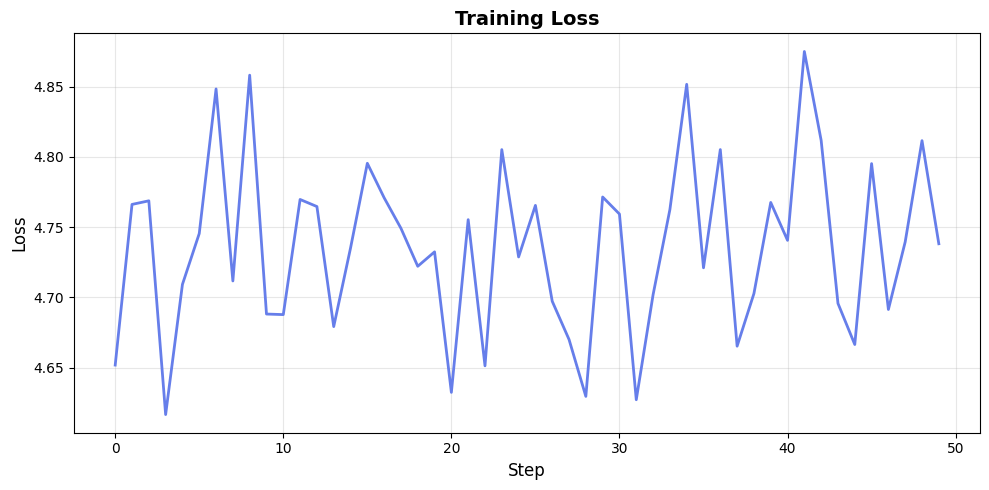


✓ Training demonstration complete!


In [10]:
# Simple training demonstration
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

model.train()
losses = []

print("Training for 50 steps...")
for step in range(50):
    # Generate random batch
    src = torch.randint(1, SRC_VOCAB_SIZE, (batch_size, src_seq_len)).to(device)
    tgt = torch.randint(1, TGT_VOCAB_SIZE, (batch_size, tgt_seq_len)).to(device)
    
    src_mask = create_padding_mask(src).to(device)
    tgt_mask = create_look_ahead_mask(tgt_seq_len).unsqueeze(0).unsqueeze(0).to(device)
    
    optimizer.zero_grad()
    
    # Forward pass
    output = model(src, tgt[:, :-1], src_mask, tgt_mask[:, :, :-1, :-1])
    
    # Calculate loss
    loss = criterion(output.reshape(-1, TGT_VOCAB_SIZE), tgt[:, 1:].reshape(-1))
    
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if (step + 1) % 10 == 0:
        print(f"  Step {step+1}/50, Loss: {loss.item():.4f}")

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(losses, linewidth=2, color='#667eea')
plt.xlabel('Step', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ Training demonstration complete!")

## 11. Visualize Attention Patterns

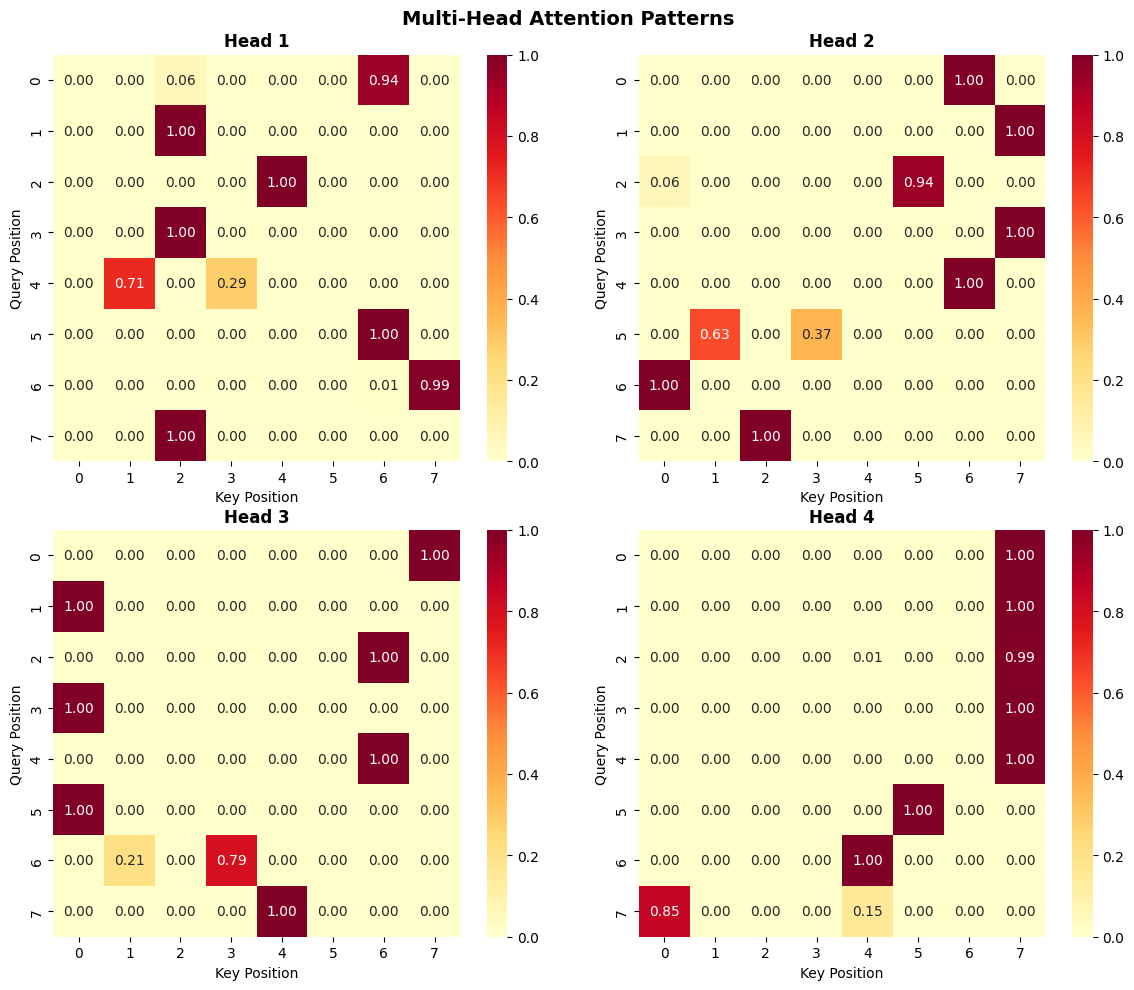


💡 Each head learns different attention patterns:
   - Some focus on adjacent tokens
   - Some focus on specific syntactic relationships
   - Some capture long-range dependencies


In [11]:
# Get attention weights from a forward pass
model.eval()
with torch.no_grad():
    src = torch.randint(1, SRC_VOCAB_SIZE, (1, 8)).to(device)
    tgt = torch.randint(1, TGT_VOCAB_SIZE, (1, 8)).to(device)
    
    src_mask = create_padding_mask(src).to(device)
    tgt_mask = create_look_ahead_mask(8).unsqueeze(0).unsqueeze(0).to(device)
    
    # Get encoder output and attention
    src_embedded = model.pos_encoding(
        model.src_embedding(src) * math.sqrt(model.d_model)
    )
    
    encoder_output = src_embedded
    for i, layer in enumerate(model.encoder_layers):
        if i == 0:  # Get attention from first encoder layer
            attn_output, attn_weights = layer.self_attn(encoder_output, encoder_output, 
                                                         encoder_output, src_mask)
            encoder_output = layer.norm1(encoder_output + layer.dropout1(attn_output))
            encoder_output = layer.norm2(encoder_output + layer.dropout2(layer.ffn(encoder_output)))
        else:
            encoder_output = layer(encoder_output, src_mask)

# Visualize attention weights from all heads
attn_weights_np = attn_weights[0].cpu().numpy()  # [num_heads, seq_len, seq_len]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i in range(NUM_HEADS):
    sns.heatmap(attn_weights_np[i], annot=True, fmt='.2f', 
                cmap='YlOrRd', ax=axes[i], cbar=True, square=True)
    axes[i].set_title(f'Head {i+1}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Key Position')
    axes[i].set_ylabel('Query Position')

plt.suptitle('Multi-Head Attention Patterns', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n💡 Each head learns different attention patterns:")
print("   - Some focus on adjacent tokens")
print("   - Some focus on specific syntactic relationships")
print("   - Some capture long-range dependencies")

## 12. Key Advantages of Transformers

### 🚀 Compared to RNN/LSTM:

| Feature | RNN/LSTM | Transformer |
|---------|----------|-------------|
| **Processing** | Sequential (slow) | Parallel (fast) |
| **Long dependencies** | Struggle (vanishing gradient) | Excel (direct connections) |
| **Training speed** | Slow | Fast (GPU-friendly) |
| **Max path length** | O(n) | O(1) |
| **Memory** | Hidden state bottleneck | All positions accessible |

### ✅ Key Innovations:

1. **Self-Attention**: Every position attends to all positions
2. **Parallel Processing**: No sequential dependency
3. **Positional Encoding**: Injects position information
4. **Multi-Head Attention**: Multiple attention perspectives
5. **Residual Connections**: Enables deep networks (100+ layers)
6. **Layer Normalization**: Stabilizes training

### 📊 Computational Complexity:

- **Self-Attention**: O(n²·d) - quadratic in sequence length
- **RNN**: O(n·d²) - linear in sequence length
- **Trade-off**: Transformers are better for sequences < 1000 tokens

### 🎯 Applications:

- 🌍 **Machine Translation** (original paper)
- 📝 **Text Generation** (GPT models)
- 🔍 **Text Understanding** (BERT models)
- 🖼️ **Vision** (Vision Transformers - ViT)
- 🎵 **Audio** (Whisper, MusicGen)
- 🧬 **Biology** (AlphaFold protein folding)

### ⚡ Modern Variants:

- **BERT**: Bidirectional encoder for understanding
- **GPT**: Unidirectional decoder for generation
- **T5**: Unified text-to-text framework
- **Vision Transformer**: Apply to images
- **Sparse Transformers**: Reduce O(n²) complexity

## 13. Summary

### Architecture Components:

```
INPUT SEQUENCE
      ↓
  EMBEDDING + POSITIONAL ENCODING
      ↓
  ┌─────────────────────┐
  │  ENCODER (N=6)     │
  │  - Self-Attention   │
  │  - Feed-Forward     │
  │  - Residual + Norm  │
  └─────────────────────┘
      ↓
  ┌─────────────────────┐
  │  DECODER (N=6)     │
  │  - Masked Self-Attn │
  │  - Cross-Attention  │
  │  - Feed-Forward     │
  │  - Residual + Norm  │
  └─────────────────────┘
      ↓
  LINEAR + SOFTMAX
      ↓
OUTPUT SEQUENCE
```

### Key Takeaways:

1. **No Recurrence**: Pure attention-based
2. **Parallel**: All positions processed simultaneously
3. **Scalable**: Works great on modern hardware
4. **Powerful**: State-of-the-art across NLP tasks
5. **Foundation**: Basis for GPT, BERT, T5, and more

**"Attention Is All You Need"** 🎯